# Sampling crvUSD Liquidity from Historical Data

We examine the historical crvUSD liquidity in the relevant stableswap pools. Notice that there are three kinds of liquidity in our simulations:

1. collateral and crvUSD in LLAMMAs <- simulated using randomly sampled debt positions (see `demo_borrowers.ipynb`).
2. crvUSD debt in StableSwap pools <- TODO (see this notebook).
3. Liquidity on "External Markets" <- simulated using an Isotonic Regressor trained on historical 1Inch quotes (see `demo_slippage_curves.ipynb`).

In [154]:
from crvusdsim.network.subgraph import _stableswap_snapshot
from curvesim.network.utils import sync
from src.utils import get_event_loop
import numpy as np
import pylab
import scipy.stats as stats
from datetime import datetime
from collections import defaultdict
from crvusdsim.pool import (
    StableCoin,
    CurveStableSwapPoolMetaData,
    CurveStableSwapPool,
    SimCurveStableSwapPool,
)
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import get_historical_user_snapshots
from src.configs import LLAMMA_ALIASES

In [180]:
CRVUSD_USDC_ADDRESS = "0x4dece678ceceb27446b35c672dc7d61f30bad69e"
CRVUSD_USDT_ADDRESS = "0x390f3595bca2df7d23783dfd126427cceb997bf4"
CRVUSD_TUSD_ADDRESS = "0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0"
CRVUSD_USDP_ADDRESS = "0xca978a0528116dda3cba9acd3e68bc6191ca53d0"

addresses = [
    CRVUSD_USDC_ADDRESS,
    CRVUSD_USDT_ADDRESS,
    CRVUSD_TUSD_ADDRESS,
    CRVUSD_USDP_ADDRESS,
]

CRVUSD_USDC_ADDRESS_ALIAS = "usdc_stableswap"
CRVUSD_USDT_ADDRESS_ALIAS = "usdt_stableswap"
CRVUSD_TUSD_ADDRESS_ALIAS = "tusd_stableswap"
CRVUSD_USDP_ADDRESS_ALIAS = "usdp_stableswap"

STABLESWAP_ALIASES = {
    CRVUSD_USDC_ADDRESS: CRVUSD_USDC_ADDRESS_ALIAS,
    CRVUSD_USDT_ADDRESS: CRVUSD_USDT_ADDRESS_ALIAS,
    CRVUSD_TUSD_ADDRESS: CRVUSD_TUSD_ADDRESS_ALIAS,
    CRVUSD_USDP_ADDRESS: CRVUSD_USDP_ADDRESS_ALIAS,
}

stableswap_snapshot = sync(_stableswap_snapshot)

In [161]:
def get_pool_stats(_snapshot):
    """
    Get the total supply from a snapshot.
    """
    snapshot = _snapshot.copy()
    snapshot["coins"] = [StableCoin(**coin_kwargs) for coin_kwargs in snapshot["coins"]]
    spool_metadata = CurveStableSwapPoolMetaData(
        snapshot, CurveStableSwapPool, SimCurveStableSwapPool
    )

    spool = SimCurveStableSwapPool(**spool_metadata.init_kwargs())

    return (
        *[b * r / 1e36 for b, r in zip(spool.balances, spool.rates)],
        spool.totalSupply / 1e18,
    )


def make_df(snapshots):
    df = pd.DataFrame(snapshots, columns=["timestamp", "peg", "crvUSD", "supply"])
    return df.set_index(pd.to_datetime(df["timestamp"], unit="s"))


def plot_liquidity_over_time(df):
    df["peg"].plot(label="peg")
    df["crvUSD"].plot(label="crvUSD")
    df["supply"].plot(label="supply")
    plt.legend()
    plt.show()


def plot_liquidity_distribution(df):
    f, axs = plt.subplots(1, 3, figsize=(15, 5))
    df["peg"].hist(grid=False, bins=25, ax=axs[0])
    axs[0].set_title("Peg Coin Distribution")
    df["crvUSD"].hist(grid=False, bins=25, ax=axs[1])
    axs[1].set_title("crvUSD Distribution")
    df["supply"].hist(grid=False, bins=25, ax=axs[2])
    axs[2].set_title("Total Supply Distribution")
    plt.show()


def probplot(df):
    f, axs = plt.subplots(1, 2)
    stats.probplot(df["peg"], dist="norm", plot=axs[0])
    stats.probplot(df["crvUSD"], dist="norm", plot=axs[1])
    plt.show()

In [157]:
start = int(datetime(2023, 10, 1).timestamp())
end = int(datetime(2024, 1, 1).timestamp())

dfs = defaultdict(list)

ts = start
while ts < end:
    snapshots = stableswap_snapshot(addresses, end_ts=ts)
    for i, address in enumerate(addresses):
        dfs[address].append([ts, *get_pool_stats(snapshots[i])])
    ts += 60 * 60 * 24

dfs = {address: make_df(df) for address, df in dfs.items()}

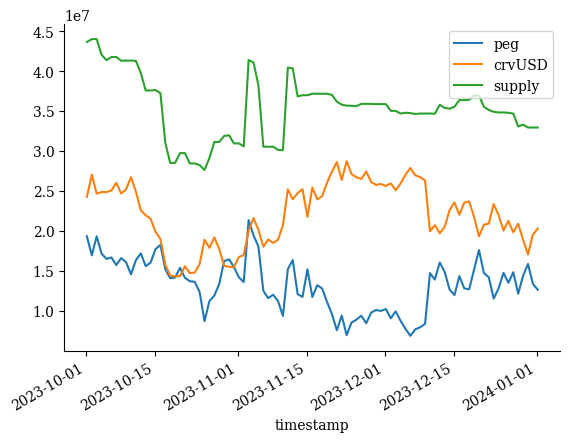

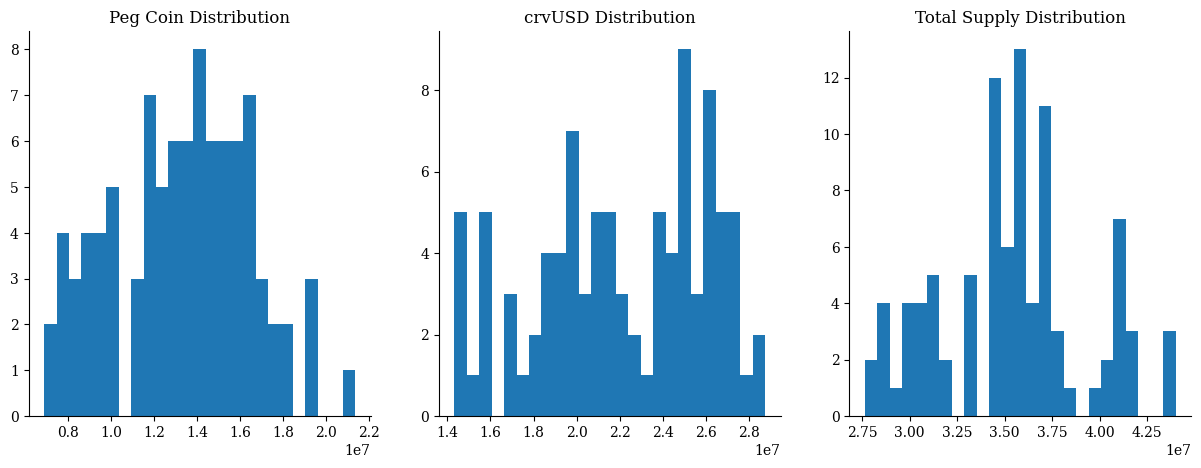

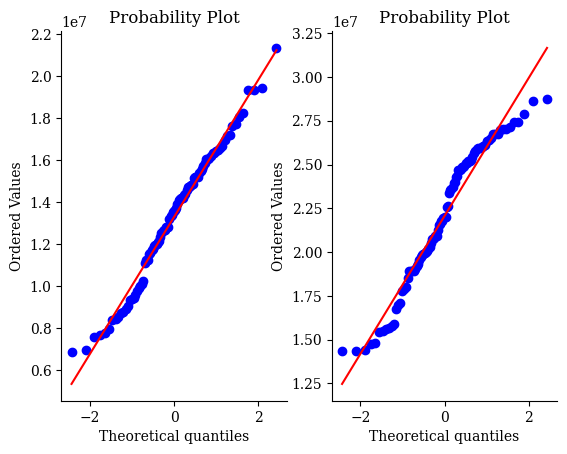

In [163]:
df = dfs[CRVUSD_USDC_ADDRESS]
plot_liquidity_over_time(df)
plot_liquidity_distribution(df)
probplot(df)

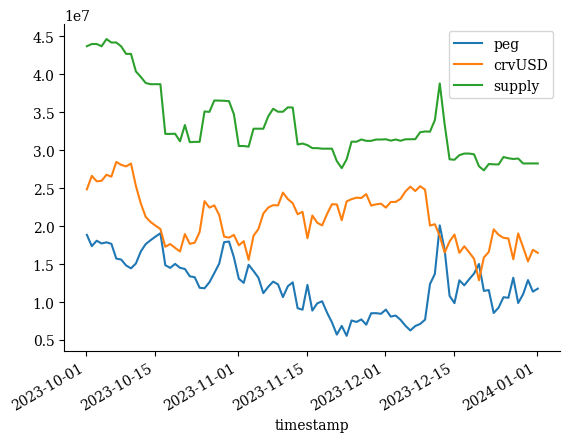

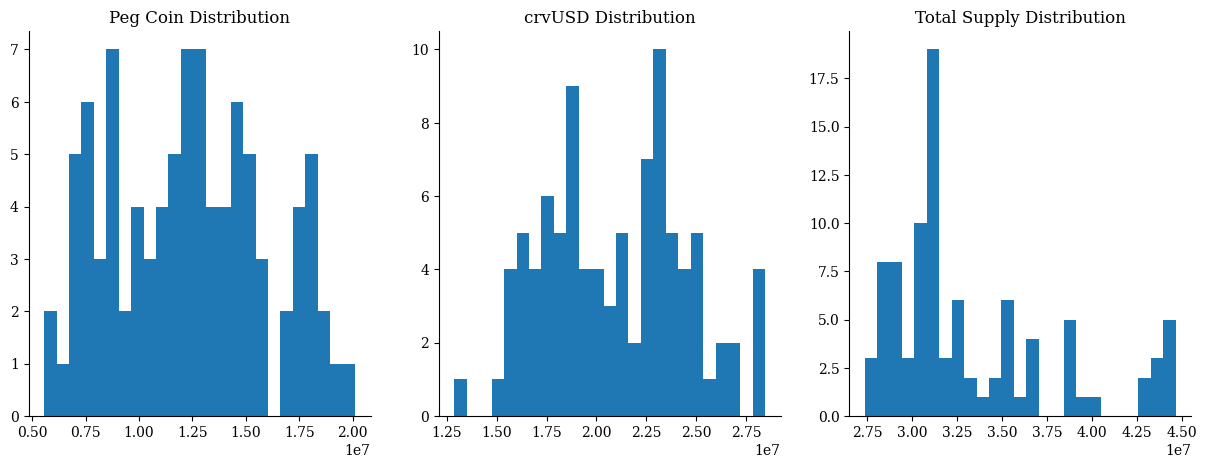

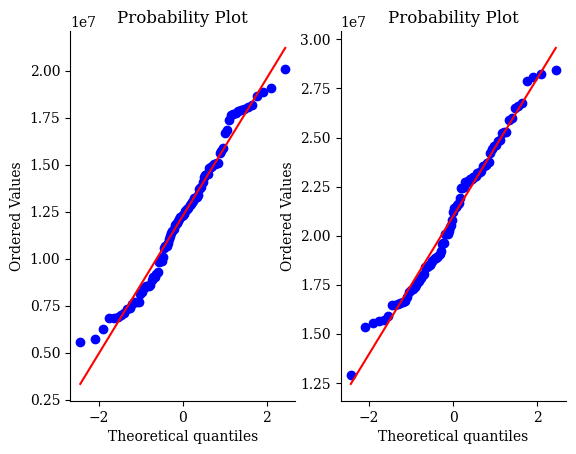

In [164]:
df = dfs[CRVUSD_USDT_ADDRESS]
plot_liquidity_over_time(df)
plot_liquidity_distribution(df)
probplot(df)

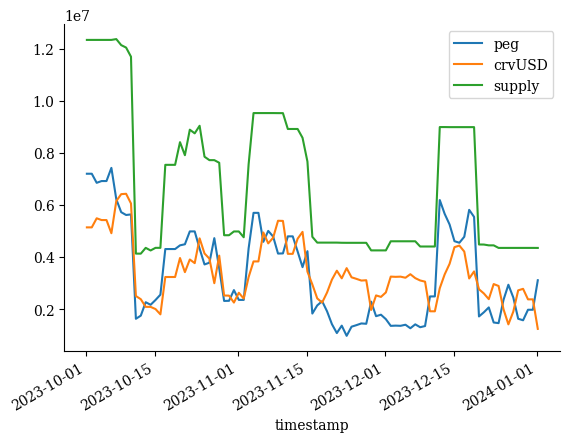

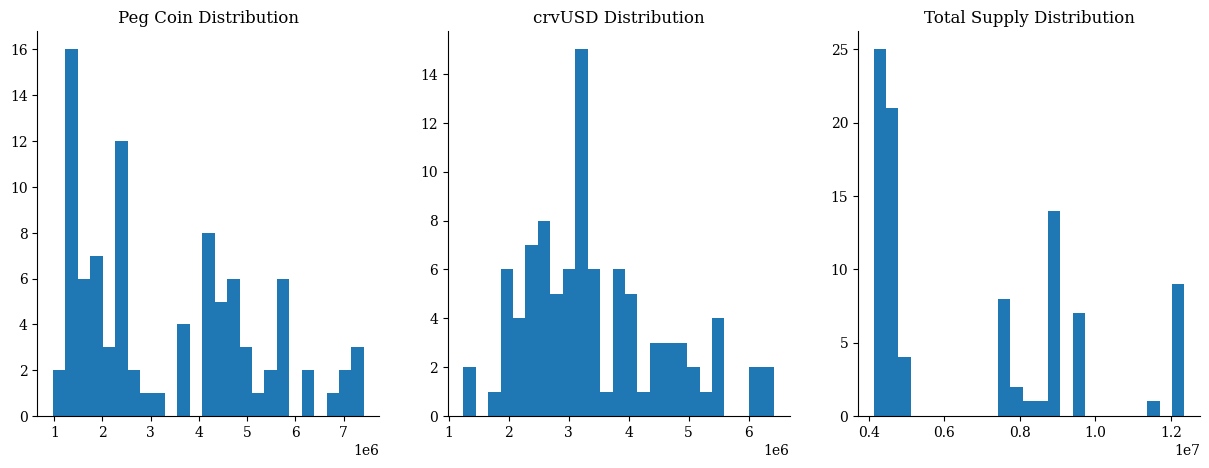

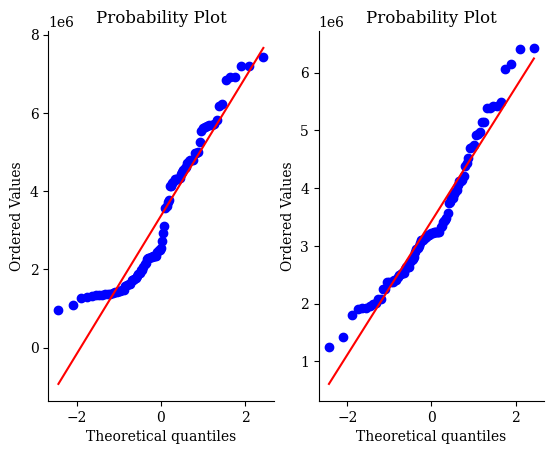

In [165]:
df = dfs[CRVUSD_TUSD_ADDRESS]
plot_liquidity_over_time(df)
plot_liquidity_distribution(df)
probplot(df)

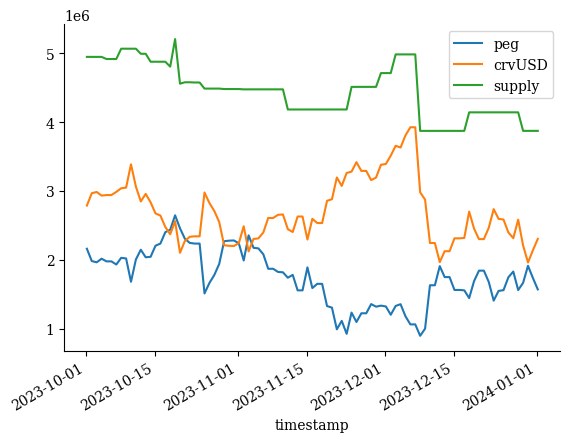

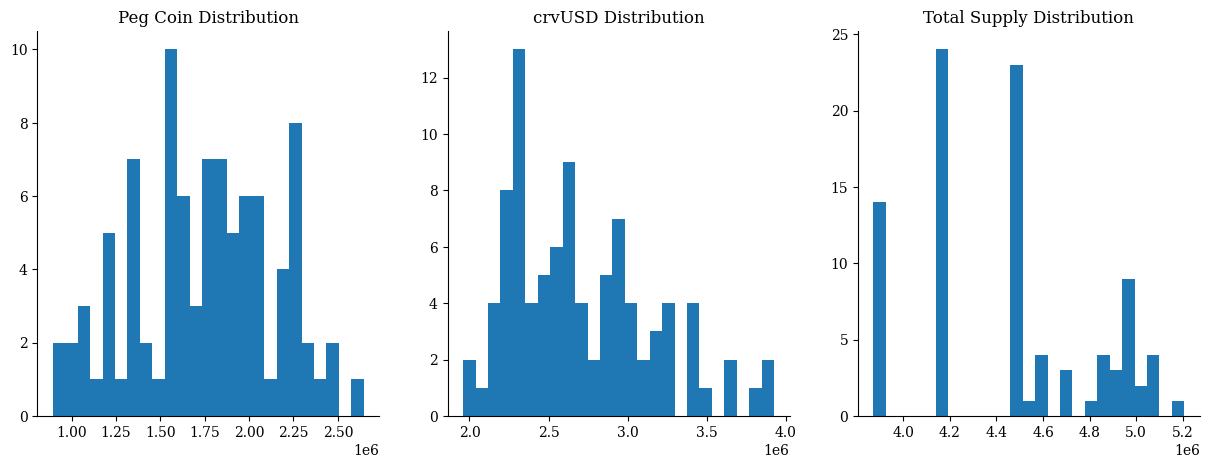

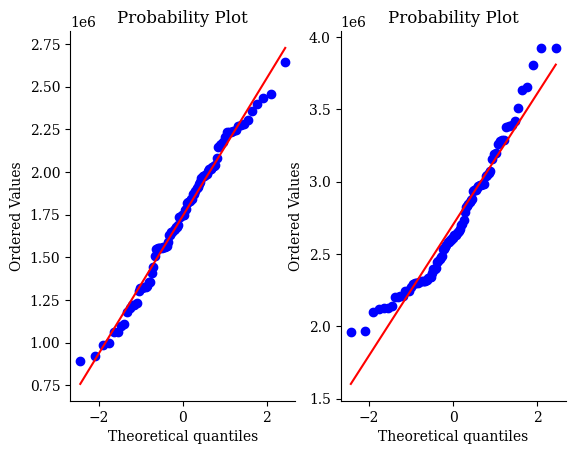

In [166]:
df = dfs[CRVUSD_USDP_ADDRESS]
plot_liquidity_over_time(df)
plot_liquidity_distribution(df)
probplot(df)

In [167]:
df = dfs[CRVUSD_USDC_ADDRESS]
data = df[["peg", "crvUSD"]].values

# Estimate parameters
mean_vector = np.mean(data, axis=0)
covariance_matrix = np.cov(data, rowvar=False)

# Sample from the joint distribution
num_samples = 1000
samples = np.random.multivariate_normal(mean_vector, covariance_matrix, num_samples)

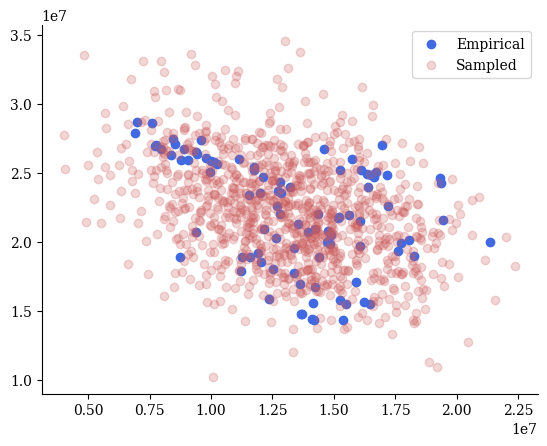

In [168]:
plt.scatter(data.T[0], data.T[1], color="royalblue", label="Empirical")
plt.scatter(samples.T[0], samples.T[1], color="indianred", label="Sampled", alpha=0.25)
plt.legend()

In [ ]:
def group(df):
    """
    Group user states df by datetime.
    """
    df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")

    return df.groupby("datetime").agg(
        debt=("debt", "sum"),
        collateral=("collateral", "sum"),
        num_loans=("debt", "count"),
    )

In [179]:
aliases = ["wsteth", "weth", "wbtc", "sfrxeth"]
grouped_data = []
for alias in aliases:
    market = LLAMMA_ALIASES[alias]
    user_states = get_historical_user_snapshots(market, start, end)
    grouped_data.append(group(user_states))

In [214]:
debts = pd.DataFrame(
    [
        df.rename(columns={"debt": alias})[alias]
        for alias, df in zip(aliases, grouped_data)
    ]
).T
debts["debt"] = debts.sum(axis=1)
debts.head()

,wsteth,weth,wbtc,sfrxeth,debt
datetime,,,,,
2023-09-30 16:04:11,4.195846e+07,5.762736e+06,4.389156e+07,9.231491e+06,1.008442e+08
2023-10-01 20:29:11,4.273815e+07,5.757250e+06,4.395752e+07,9.261179e+06,1.017141e+08
2023-10-02 20:00:11,4.292228e+07,6.207339e+06,4.335811e+07,9.079936e+06,1.015677e+08
2023-10-03 20:20:47,4.069514e+07,6.170375e+06,4.701885e+07,1.000663e+07,1.038910e+08
2023-10-04 20:17:59,4.056311e+07,6.148231e+06,4.705074e+07,1.001299e+07,1.037751e+08


In [215]:
liquidity = pd.DataFrame(
    [
        df.rename(columns={"crvUSD": STABLESWAP_ALIASES[address]})[
            STABLESWAP_ALIASES[address]
        ]
        for address, df in dfs.items()
    ]
).T
liquidity["liquidity"] = liquidity.sum(axis=1)
liquidity.head()

,usdc_stableswap,usdt_stableswap,tusd_stableswap,usdp_stableswap,liquidity
timestamp,,,,,
2023-10-01 04:00:00,2.429347e+07,2.485379e+07,5.136401e+06,2.787582e+06,5.707124e+07
2023-10-02 04:00:00,2.704362e+07,2.663157e+07,5.136401e+06,2.966675e+06,6.177826e+07
2023-10-03 04:00:00,2.467229e+07,2.591386e+07,5.484620e+06,2.985026e+06,5.905579e+07
2023-10-04 04:00:00,2.487149e+07,2.598123e+07,5.416854e+06,2.932290e+06,5.920186e+07
2023-10-05 04:00:00,2.486477e+07,2.677640e+07,5.416854e+06,2.940335e+06,5.999836e+07


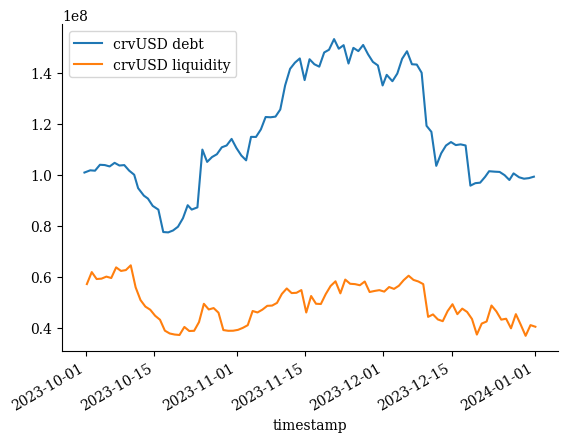

In [216]:
debts["debt"].plot(label=f"crvUSD debt")
liquidity["liquidity"].plot(label=f"crvUSD liquidity")
plt.legend()

In [217]:
np.corrcoef(debts["debt"], liquidity["liquidity"])

array([[1.        , 0.58467953],
       [0.58467953, 1.        ]])

<Axes: >

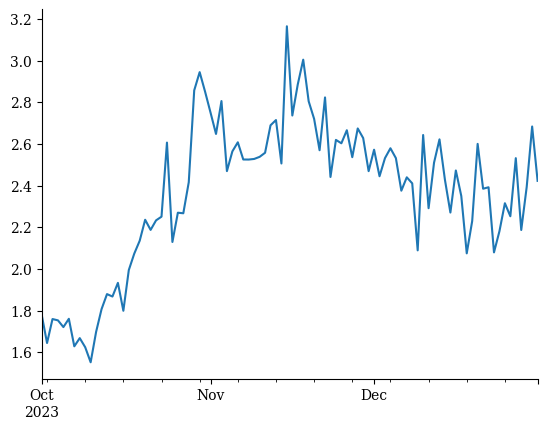

In [218]:
debt_resampled = debts["debt"].resample("1d").mean()
liquidity_resampled = liquidity["liquidity"].resample("1d").mean()
ratio = (debt_resampled / liquidity_resampled).dropna()
ratio.plot()

In [219]:
ratio.describe()

count    92.000000
mean      2.362817
std       0.362057
min       1.551653
25%       2.169457
50%       2.440397
75%       2.606633
max       3.164624
dtype: float64